# Plotting helper functions for Speckle analysis -- `xray_vision.mpl_plotting.speckle` module

In [1]:
import xray_vision.mpl_plotting.speckle as speckle_plot
import xray_vision.mpl_plotting as mpl_plot
# imports... all the imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.ticker as mticks
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_grid import ImageGrid

import skxray.core.roi as roi
import skxray.core.correlation as corr
import skxray.core.utils as core
import scipy.ndimage.measurements as ndim

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Easily switch between interactive and static matplotlib plots

In [2]:
interactive_mode = False

if interactive_mode:
    %matplotlib notebook
else:
    %matplotlib inline

backend = mpl.get_backend()

#  Where does this data come from?
L. Li, P. Kwasniewski, D. Oris, L Wiegart, L. Cristofolini,
C. Carona and A. Fluerasu , "Photon statistics and speckle
visibility spectroscopy with partially coherent x-rays" J.
Synchrotron Rad., vol 21, p 1288-1295, 2014.

In [3]:
%run download.py

__file__
current_folder = /home/edill/dev/python/scikit-xray-examples/demos/speckle
current_folder = /home/edill/dev/python/scikit-xray-examples/demos/speckle


## Load the data

In [4]:
# we will provide a link to the data once it is approved 
# for distribution by Dr. Fluerasu
data_dir = "Duke_data/"
duke_ndata = np.load(data_dir+"duke_img_1_5000.npy")
duke_dark = np.load(data_dir+"duke_dark.npy")

## Define the image metadata

In [5]:
pixel_size = (0.1, 0.1)  # in mm
image_center = (133, 143) # in pixels
# if we are 1.5 or later
if float('.'.join(mpl.__version__.split('.')[:2])) >= 1.5:
    cmap = 'viridis'
else:
    cmap = 'CMRmap'


# Let's pretend like this is data from 5 different points in the sample
We are doing this to demonstrate the use cases at CHX

The next few cells will result in a dictionary of 5 data sets

In [6]:
# fake that this is 5 different points in the same sample
splits = [0, 500, 1500, 2000, 3500, duke_ndata.shape[0]]
split_data = []
ranges = []
for lower, upper in zip(splits, splits[1:]):
    split_data.append(duke_ndata[lower:upper])
    ranges.append('%s:%s' % (lower, upper))
    
data_labels = ['sample_point_%s' % (i+1) for i, region in 
               zip(range(len(split_data)), ranges)]

data_dict = {label: data for label, data in 
             zip(data_labels, split_data)}

In [7]:
# subtract the dark image from the dataset
data_dict = {label: data - duke_dark for label, data in 
             data_dict.items()}

In [8]:
# load the mask(s) and mask the data
mask1 = np.load(data_dir+"new_mask4.npy")
mask2 = np.load(data_dir+"Luxi_duke_mask.npy")

mask = mask1 + mask2

masked_data = {label: data * mask for label, data in data_dict.items()}

## Plot the masks

use the ImageGrid to make this plot look very nice because it handles a lot of annoying setup bits, such as:
- show axis labels only on the left/bottom of the image panels
- easily handle colorbar formatting
- easily specify horizontal and vertical spacings between the image panels
- Zoom/pan all images together

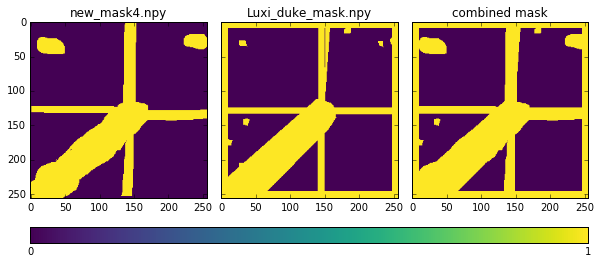

In [9]:
fig = plt.figure(figsize=(10, 4))
from mpl_toolkits.axes_grid1.axes_grid import ImageGrid
grid = ImageGrid(fig, '111', nrows_ncols=(1, 3), share_all=True, 
                 axes_pad=0.2, label_mode="L", cbar_location="bottom", 
                 cbar_mode="single", cbar_size='3%')
# plot the images
im1 = grid[0].imshow(mask1, cmap=cmap)
im2 = grid[1].imshow(mask2, cmap=cmap)
im3 = grid[2].imshow(mask, cmap=cmap)

# instantiate the colorbar
grid.cbar_axes[0].colorbar(im3, ticks=mticks.MaxNLocator(integer=True))

# set the titles of the axes
grid[0].set_title('new_mask4.npy')
grid[1].set_title('Luxi_duke_mask.npy')
grid[2].set_title('combined mask')

if 'inline' in backend:
    plt.show()

#Oops, the masks are reversed!
We want the pixels to keep to be '1' and the pixels to discard to be '0'

In [10]:
# load the mask(s) and mask the data
mask1 = ~mask1
mask2 = ~mask2

mask = ~mask

masked_data = {label: data * mask for label, data in data_dict.items()}

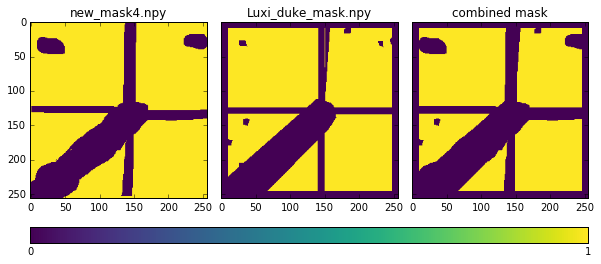

In [11]:
fig = plt.figure(figsize=(10, 4))
from mpl_toolkits.axes_grid1.axes_grid import ImageGrid
grid = ImageGrid(fig, '111', nrows_ncols=(1, 3), share_all=True, 
                 axes_pad=0.2, label_mode="L", cbar_location="bottom", 
                 cbar_mode="single", cbar_size='3%')
# plot the images
im1 = grid[0].imshow(mask1, cmap=cmap)
im2 = grid[1].imshow(mask2, cmap=cmap)
im3 = grid[2].imshow(mask, cmap=cmap)

# instantiate the colorbar
grid.cbar_axes[0].colorbar(im3, ticks=mticks.MaxNLocator(integer=True))

# set the titles of the axes
grid[0].set_title('new_mask4.npy')
grid[1].set_title('Luxi_duke_mask.npy')
grid[2].set_title('combined mask')

if 'inline' in backend:
    plt.show()

# There we go. That looks better!

# Let's look at the total dataset pre- and post-masking

In [12]:
# compute the average raw and masked images
avg_raw = np.average(np.vstack(data_dict.values()), axis=0)
avg_masked = np.average(np.vstack(masked_data.values()), axis=0)

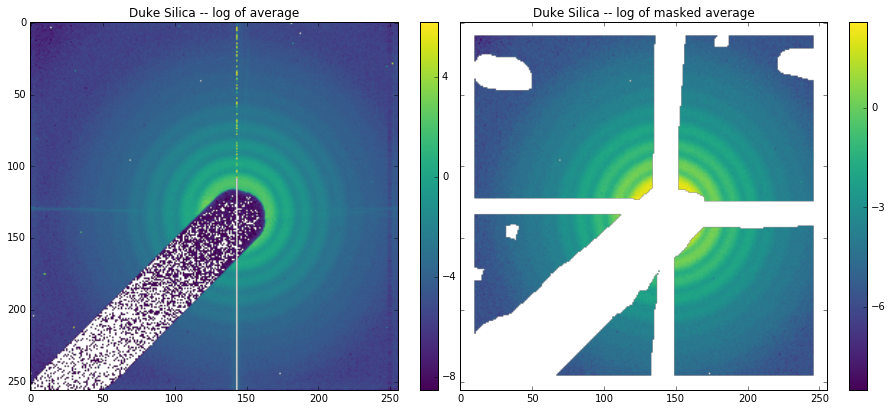

In [13]:
fig = plt.figure(figsize=(15, 7))
grid = ImageGrid(fig, (1,1,1), nrows_ncols=(1, 2), share_all=True, 
                 cbar_mode='each', axes_pad=.3)
cmap = 'viridis'
im1 = grid[0].imshow(np.log(avg_raw), cmap=cmap)
im2 = grid[1].imshow(np.log(avg_masked), cmap=cmap)

grid[0].set_title("Duke Silica -- log of average")
grid[1].set_title("Duke Silica -- log of masked average")

grid.cbar_axes[0].colorbar(im1)
grid.cbar_axes[1].colorbar(im2)
# the following code is needed to make it easy to switch 
# between '%matplotlib inline' and '%matplotlib notebook'
if 'inline' in backend:
    plt.show()

# Use the `skxray.core.roi` module to easily create ring ROIs

In [14]:
# define the parameters for the ring regions of interest
starting_radius = 26
ring_width = 8
space_between_rings = 1
num_rings = 4
# image center was defined when we loaded the data

# get the inner/outer radii of the rings
ring_edges = roi.ring_edges(starting_radius, ring_width, space_between_rings, num_rings)
print('ring_edges are defined as [inner_radius, outer_radius]:\n%s' % ring_edges)
ring_centers = np.average(ring_edges, axis=1)
print('\nring_centers: %s' % ring_centers)

# rings is a labeled array where 0 is background and 1-4 are ROIS 1-4.
rings = roi.rings(edges=ring_edges, center=image_center, shape=avg_raw.shape)

# multiplying the rings with the image mask removes the bad information (beam stop, beam stop scatter, 
# bad pixels, etc..) from the rings ROI. See the plot below
rings_mask = rings*mask

ring_edges are defined as [inner_radius, outer_radius]:
[[ 26.  34.]
 [ 35.  43.]
 [ 44.  52.]
 [ 53.  61.]]

ring_centers: [ 30.  39.  48.  57.]


## Let's look at what these ring ROIs look like.
again, use ImageGrid to nicely format the plot

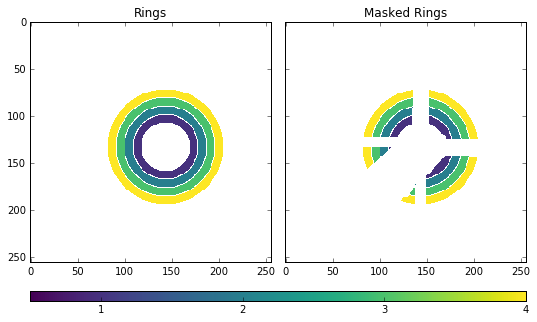

In [15]:
fig = plt.figure(figsize=(10, 5))
grid = ImageGrid(fig, '111', nrows_ncols=(1, 2), share_all=True, axes_pad=0.2, 
                 label_mode="L", cbar_location="bottom", cbar_mode="single", cbar_size='2%')
im1 = mpl_plot.show_label_array(grid[0], rings, cmap=cmap)
im2 = mpl_plot.show_label_array(grid[1], rings_mask, cmap=cmap)
# turn on the colorbar
grid.cbar_axes[0].colorbar(im1, ticks=mticks.MaxNLocator(integer=True))
grid[0].set_title('Rings')
grid[1].set_title('Masked Rings')

if 'inline' in backend:
    plt.show()

# These ROIs are looking good! Let's make sure that each point in the sample is behaving similarly

# Use the `skxray.core.roi module` to compute the mean intensity for each ROI for each sample.
This uses the `roi.mean_intensity` function which takes in ONE image stack and returns a list of arrays where the arrays correspond to the average intensity for each ROI.

In [16]:
masked_data['sample_point_1'].shape

(500, 256, 256)

In [17]:
intensity, index_list = roi.mean_intensity(masked_data['sample_point_1'], rings_mask)

In [18]:
intensity.shape

(500, 4)

In [24]:
roi_data = {}
for k, v in sorted(masked_data.items()):
    intensity, index_list = roi.mean_intensity(v, rings_mask)
    roi_data[k] = [arr for arr in intensity.T]
#     roi_data[k] = intensity
# one line dict comprehension
# roi_data = {k: roi.mean_intensity(v, rings_mask) for k, v in masked_data.items()}
row_labels = ['roi_%s' % i for i in index_list]
df = pd.DataFrame(roi_data, row_labels)

In [25]:
df

,sample_point_1,sample_point_2,sample_point_3,sample_point_4,sample_point_5
roi_1,"[1.10843373494, 1.13403614458, 1.17921686747, ...","[1.27409638554, 1.23493975904, 1.17168674699, ...","[1.21234939759, 1.26355421687, 1.19126506024, ...","[1.23945783133, 1.27259036145, 1.17168674699, ...","[1.2078313253, 1.19126506024, 1.17018072289, 1..."
roi_2,"[0.608735213831, 0.61601455869, 0.617834394904...","[0.623293903549, 0.630573248408, 0.64695177434...","[0.6296633303, 0.65059144677, 0.676979071884, ...","[0.639672429481, 0.659690627843, 0.60054595086...","[0.582347588717, 0.606005459509, 0.59326660600..."
roi_3,"[0.275794938352, 0.283582089552, 0.32057105775...","[0.290071382219, 0.292018170019, 0.29915639195...","[0.284231018819, 0.304347826087, 0.30369889682...","[0.310188189487, 0.292018170019, 0.30175210902...","[0.327060350422, 0.296560674886, 0.29850746268..."
roi_4,"[0.12229491696, 0.123301459487, 0.121288374434...","[0.119778560644, 0.12380473075, 0.105183694011...","[0.129843985908, 0.121288374434, 0.11675893306...","[0.114745848012, 0.120281831907, 0.11977856064...","[0.133366884751, 0.119275289381, 0.11726220432..."


# Let's look at the data in this dataframe.
We will use the `mean_intensity_plotter` function in the `xray_vision.mpl_plotting.speckle` module, which we imported as `speckle_plot`

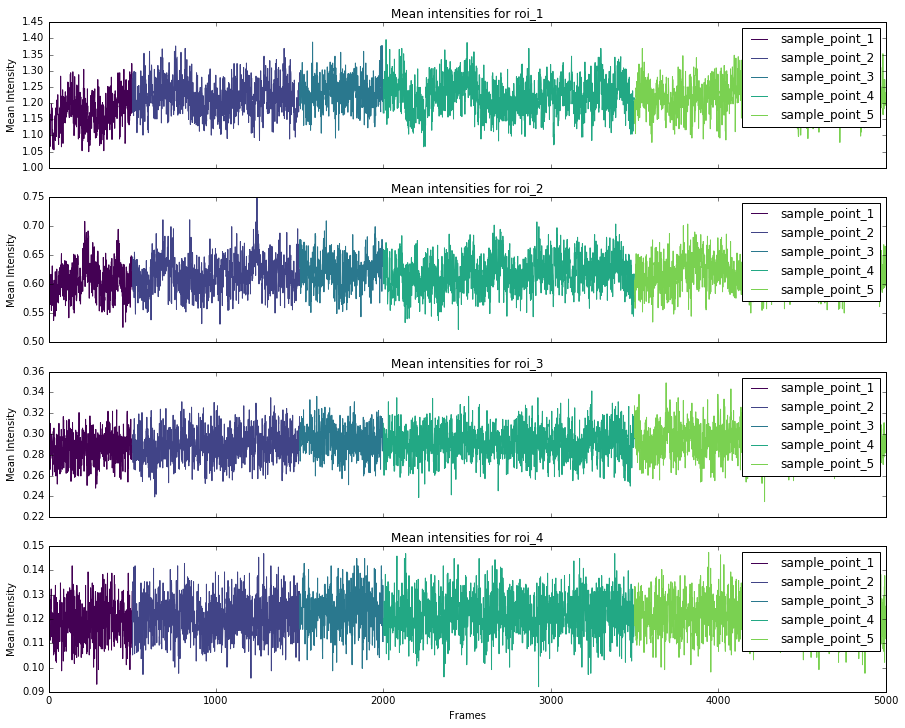

In [26]:
# fig, ax = plt.subplots(len(df.index))
fig, ax = plt.subplots(len(df.index), figsize=(15, 12), sharex=True)
arts = speckle_plot.mean_intensity_plotter(ax, df, cmap=cmap)

if 'inline' in backend:
    plt.show()
    

# Things look good!  Let's probe the return value of the `mean_intensity_plotter` function
What does the return value of speckle_plot.mean_intensity_plotter look like?

In [27]:
arts

,sample_point_1,sample_point_2,sample_point_3,sample_point_4,sample_point_5
roi_1,Line2D(sample_point_1),Line2D(sample_point_2),Line2D(sample_point_3),Line2D(sample_point_4),Line2D(sample_point_5)
roi_2,Line2D(sample_point_1),Line2D(sample_point_2),Line2D(sample_point_3),Line2D(sample_point_4),Line2D(sample_point_5)
roi_3,Line2D(sample_point_1),Line2D(sample_point_2),Line2D(sample_point_3),Line2D(sample_point_4),Line2D(sample_point_5)
roi_4,Line2D(sample_point_1),Line2D(sample_point_2),Line2D(sample_point_3),Line2D(sample_point_4),Line2D(sample_point_5)


If you guessed "a dataframe", then you would be correct!  It is returning the matplotlib artists in the same layout as the data that was passed in.  

What is a matplotlib artist?  It is the thing that you can modify to change the appearance of the plot after it has been created.  There is a "gotcha" here. If you are using matplotlib in "inline" mode (%matplotlib inline) then you will not be able to interactively modify a figure. Go back to the second cell code cell and make sure that "interactive" is set to True, if you want interactive plots.  Then come back and play around with the next few cells. Otherwise, skip them.

In [28]:
arts.sample_point_1.roi_1.set_color('pink')

### If you are using matplotlib in interactive mode, go look at the above figure again. The left-most like in the top plot should now be pink!

#At this point, this dataset looks fine.  To illustrate how we would go about cleaning this data if one of the points in the sample was not "good", we have to manipulate the data. Let's do that now.
Let's pretend that there is an issue with the second sample (point_2)

Obviously there is not a problem, but if we want to use the helper function that removes a dataset

In [29]:
# make a copy of the dataframe so that we can mess it up for tutorial purposes
bad_df = df.copy()

In [30]:
bad_df['sample_point_2'] = bad_df['sample_point_2'] * 1.1

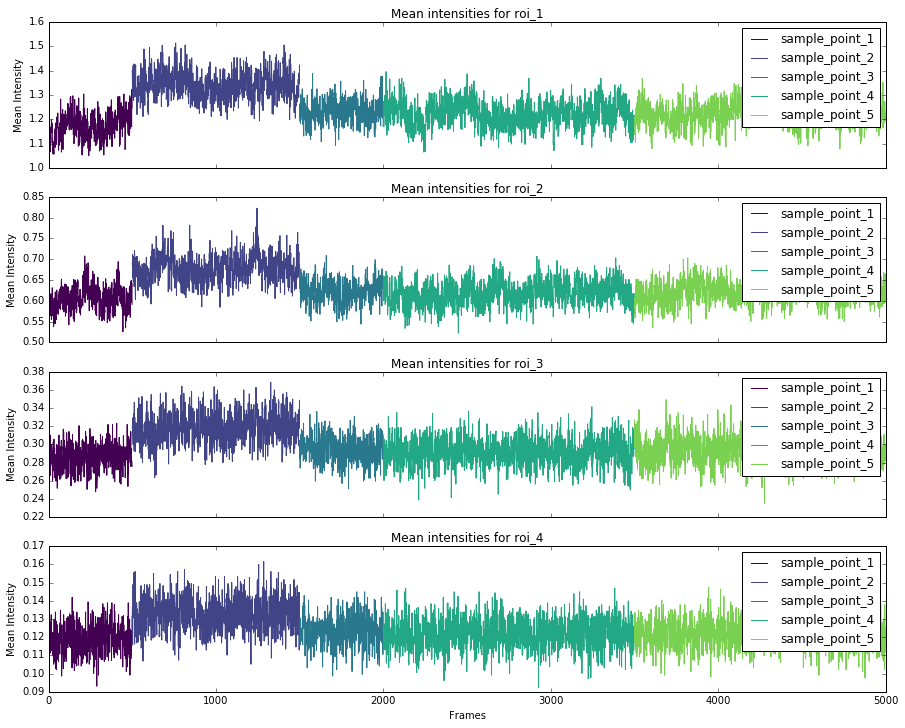

In [31]:
# fig, ax = plt.subplots(len(df.index))
fig, ax = plt.subplots(len(bad_df.index), figsize=(15, 12), sharex=True)
arts = speckle_plot.mean_intensity_plotter(ax, bad_df, cmap=cmap)

if 'inline' in backend:
    plt.show()
    

## Oh no! There seems to be an issue with "sample_point_2". Let's remove that from the image list

# Very short pandas tutorial: drop a column
Note that this returns a new dataframe. Use the 'inplace' kwarg if you want to modify the dataframe in-place

In [32]:
dropped_column = df.drop('sample_point_2', axis=1)
# dropped_column = df.drop('point_2', axis=1, inplace=True)

In [33]:
dropped_column

,sample_point_1,sample_point_3,sample_point_4,sample_point_5
roi_1,"[1.10843373494, 1.13403614458, 1.17921686747, ...","[1.21234939759, 1.26355421687, 1.19126506024, ...","[1.23945783133, 1.27259036145, 1.17168674699, ...","[1.2078313253, 1.19126506024, 1.17018072289, 1..."
roi_2,"[0.608735213831, 0.61601455869, 0.617834394904...","[0.6296633303, 0.65059144677, 0.676979071884, ...","[0.639672429481, 0.659690627843, 0.60054595086...","[0.582347588717, 0.606005459509, 0.59326660600..."
roi_3,"[0.275794938352, 0.283582089552, 0.32057105775...","[0.284231018819, 0.304347826087, 0.30369889682...","[0.310188189487, 0.292018170019, 0.30175210902...","[0.327060350422, 0.296560674886, 0.29850746268..."
roi_4,"[0.12229491696, 0.123301459487, 0.121288374434...","[0.129843985908, 0.121288374434, 0.11675893306...","[0.114745848012, 0.120281831907, 0.11977856064...","[0.133366884751, 0.119275289381, 0.11726220432..."


Note that there is no `point_2` column any more. However, the original dataframe remains unchanged

In [34]:
df

,sample_point_1,sample_point_2,sample_point_3,sample_point_4,sample_point_5
roi_1,"[1.10843373494, 1.13403614458, 1.17921686747, ...","[1.27409638554, 1.23493975904, 1.17168674699, ...","[1.21234939759, 1.26355421687, 1.19126506024, ...","[1.23945783133, 1.27259036145, 1.17168674699, ...","[1.2078313253, 1.19126506024, 1.17018072289, 1..."
roi_2,"[0.608735213831, 0.61601455869, 0.617834394904...","[0.623293903549, 0.630573248408, 0.64695177434...","[0.6296633303, 0.65059144677, 0.676979071884, ...","[0.639672429481, 0.659690627843, 0.60054595086...","[0.582347588717, 0.606005459509, 0.59326660600..."
roi_3,"[0.275794938352, 0.283582089552, 0.32057105775...","[0.290071382219, 0.292018170019, 0.29915639195...","[0.284231018819, 0.304347826087, 0.30369889682...","[0.310188189487, 0.292018170019, 0.30175210902...","[0.327060350422, 0.296560674886, 0.29850746268..."
roi_4,"[0.12229491696, 0.123301459487, 0.121288374434...","[0.119778560644, 0.12380473075, 0.105183694011...","[0.129843985908, 0.121288374434, 0.11675893306...","[0.114745848012, 0.120281831907, 0.11977856064...","[0.133366884751, 0.119275289381, 0.11726220432..."


# Very short pandas tutorial: drop a row
Note that this returns a new dataframe. Use the 'inplace' kwarg if you want to modify the dataframe in-place

In [35]:
dropped_row = df.drop(df.index[[2]])
# dropped_row = df.drop(df.index[[2]], inplace=False)

In [36]:
dropped_row

,sample_point_1,sample_point_2,sample_point_3,sample_point_4,sample_point_5
roi_1,"[1.10843373494, 1.13403614458, 1.17921686747, ...","[1.27409638554, 1.23493975904, 1.17168674699, ...","[1.21234939759, 1.26355421687, 1.19126506024, ...","[1.23945783133, 1.27259036145, 1.17168674699, ...","[1.2078313253, 1.19126506024, 1.17018072289, 1..."
roi_2,"[0.608735213831, 0.61601455869, 0.617834394904...","[0.623293903549, 0.630573248408, 0.64695177434...","[0.6296633303, 0.65059144677, 0.676979071884, ...","[0.639672429481, 0.659690627843, 0.60054595086...","[0.582347588717, 0.606005459509, 0.59326660600..."
roi_4,"[0.12229491696, 0.123301459487, 0.121288374434...","[0.119778560644, 0.12380473075, 0.105183694011...","[0.129843985908, 0.121288374434, 0.11675893306...","[0.114745848012, 0.120281831907, 0.11977856064...","[0.133366884751, 0.119275289381, 0.11726220432..."


Note that there is no `roi_3` anymore. However, the original dataframe remains unchanged

# Ok, so let's drop the bad data for "point_2"

In [37]:
bad_data = ['sample_point_2']
# drop, by default, returns a copy of the dataframe. If you want to update it in-place, use 'inplace=True'
cleaned_df = bad_df.drop(bad_data, axis=1)
# bad_df.drop('point_2', axis=1, inplace=True)

In [38]:
cleaned_df

,sample_point_1,sample_point_3,sample_point_4,sample_point_5
roi_1,"[1.10843373494, 1.13403614458, 1.17921686747, ...","[1.21234939759, 1.26355421687, 1.19126506024, ...","[1.23945783133, 1.27259036145, 1.17168674699, ...","[1.2078313253, 1.19126506024, 1.17018072289, 1..."
roi_2,"[0.608735213831, 0.61601455869, 0.617834394904...","[0.6296633303, 0.65059144677, 0.676979071884, ...","[0.639672429481, 0.659690627843, 0.60054595086...","[0.582347588717, 0.606005459509, 0.59326660600..."
roi_3,"[0.275794938352, 0.283582089552, 0.32057105775...","[0.284231018819, 0.304347826087, 0.30369889682...","[0.310188189487, 0.292018170019, 0.30175210902...","[0.327060350422, 0.296560674886, 0.29850746268..."
roi_4,"[0.12229491696, 0.123301459487, 0.121288374434...","[0.129843985908, 0.121288374434, 0.11675893306...","[0.114745848012, 0.120281831907, 0.11977856064...","[0.133366884751, 0.119275289381, 0.11726220432..."


## Yay, no more point_2!

## Now we need to recombine the data that is currently stored in the dataframe

In [39]:
roi_data = {roi: np.hstack(data) for roi, data in df.iterrows()}

In [40]:
roi_data

{'roi_1': array([ 1.10843373,  1.13403614,  1.17921687, ...,  1.19277108,
         1.23343373,  1.2063253 ]),
 'roi_2': array([ 0.60873521,  0.61601456,  0.61783439, ...,  0.61874431,
         0.66515014,  0.63148317]),
 'roi_3': array([ 0.27579494,  0.28358209,  0.32057106, ...,  0.29980532,
         0.2816353 ,  0.28552888]),
 'roi_4': array([ 0.12229492,  0.12330146,  0.12128837, ...,  0.12531454,
         0.11877202,  0.12229492])}

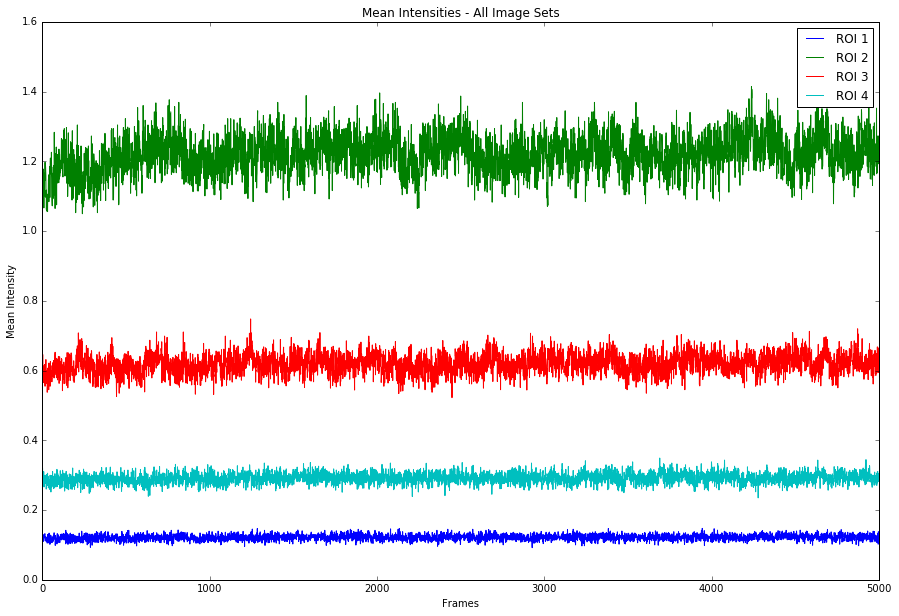

In [41]:
fig, ax = plt.subplots(figsize=(15, 10))
speckle_plot.combine_intensity_plotter(ax, roi_data.values())
if 'inline' in backend:
    plt.show()

# Circular average(radial integration) of the intensity distribution of the image data.
Compute the average without the bad data

drop the `bad_data` from `data`

In [42]:
for bad in bad_data:
    del masked_data[bad]

### Demonstrate that all keys in `bad_data` are no longer in `masked_data`

In [43]:
masked_data.keys()

dict_keys(['sample_point_1', 'sample_point_3', 'sample_point_4', 'sample_point_5'])

### Compute the average image from the remaining data in `masked_data`

In [44]:
average_images = {k: np.sum(data, axis=0) for k, data 
                  in masked_data.items()}

In [45]:
averages = {}
for name, data in average_images.items():
    averages[name] = roi.circular_average(data, calibrated_center=image_center, 
                                          threshold=0, nx=100, pixel_size=pixel_size)


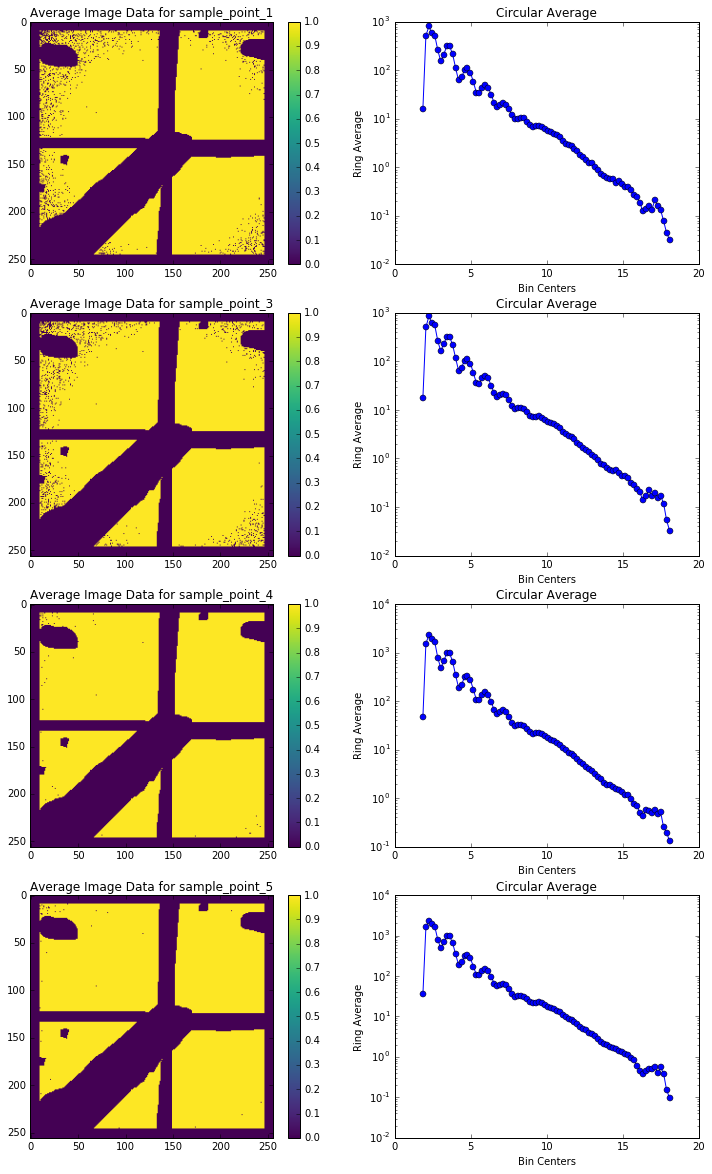

In [46]:
fig, axes = plt.subplots(nrows=len(averages.keys()), ncols=2, figsize=(12, 20))
im_kw = {'vmax': 1, 'cmap': cmap}
line_kw = {'c': 'blue', 'marker': 'o'}
keys = sorted(list(averages.keys()))
for k,  ax in zip(keys, axes):
    bin_centers, ring_averages = averages[k]
    im, line = speckle_plot.circular_average(ax, average_images[k], ring_averages, bin_centers, 
                                          im_kw=im_kw, line_kw=line_kw, 
                                          im_title='Average Image Data for %s' % k)
if 'inline' in backend:
    plt.show()

# Data for graphical representation of pixels variation over time for required ROI.

In [47]:
roi_kymograph = roi.kymograph(masked_data['sample_point_1'], rings_mask, num=2)

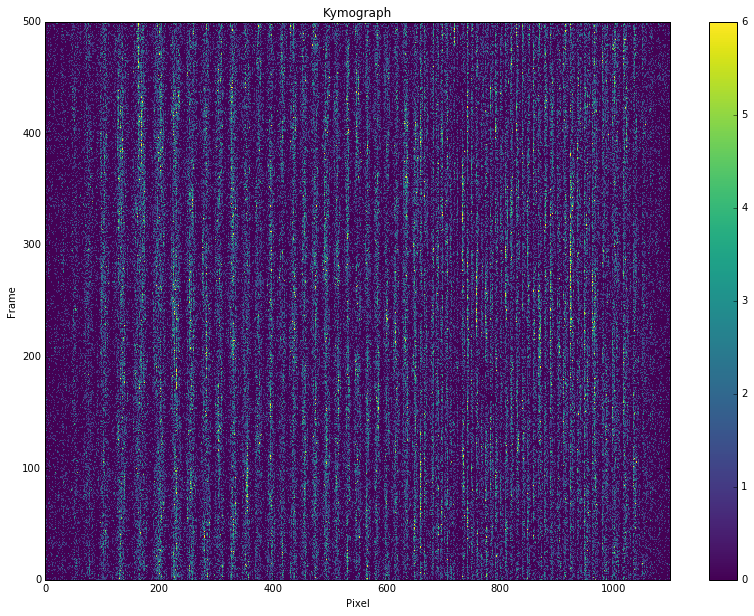

In [48]:
fig, ax = plt.subplots(figsize=(14,10))
ax.set_xlabel('Pixel')
ax.set_ylabel('Frame')
ax.set_title('Kymograph')

plot_kw = {
    'cmap': 'viridis',
    'vmin': 0,
    'vmax': 6,
    'interpolation': 'nearest',
    'aspect': 'auto',
}

im, cb = speckle_plot.kymograph(ax, roi_kymograph, **plot_kw)
# speckle_plot.roi_kymograph_plotter(ax, roi_kymograph)
if 'inline' in backend:
    plt.show()

# This will provide intensities of the ROI's of the labeled array according to the pixel list

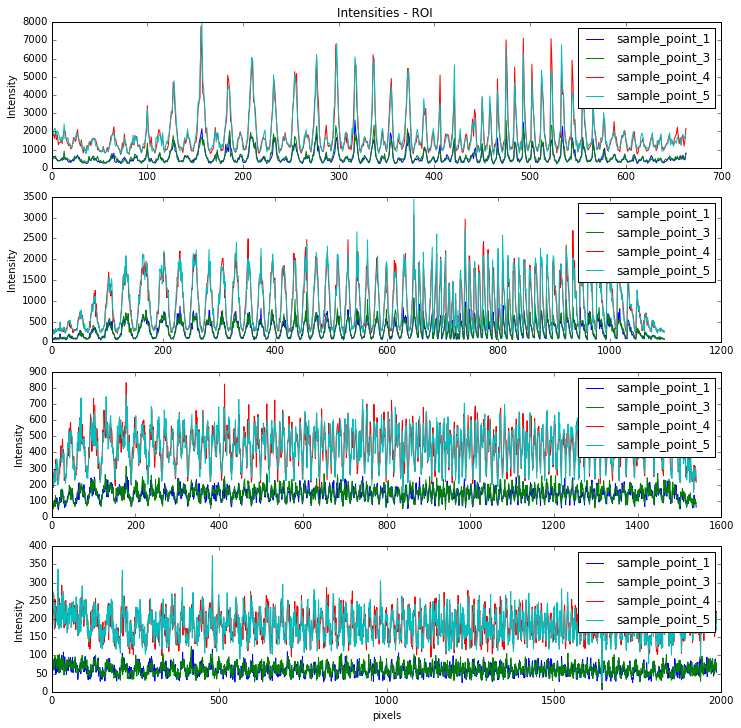

In [49]:
fig, ax = plt.subplots((len(average_images)), figsize=(12, 12))
for label, image in average_images.items():
    roi_pixel_values, index = roi.roi_pixel_values(image, rings_mask)
    speckle_plot.rois_as_lines(ax, roi_pixel_values, 
                               labels=[label]*len(image))
if 'inline' in backend:
    plt.show()

In [50]:
import skxray

In [51]:
skxray.__version__

'0.0.4+95.gb764d5c'